In [1]:
import xarray as xr

path='D:/VScode/Last_deglaciation/data_fig3/'
trace_orb = xr.open_dataset(path + 'b30.00_4kaDVTj.cam2.ncrcat.ann.nc')
trace_ghg= xr.open_dataset(path + 'b30.00_4kaDVTk.cam2.ncrcat.ann.nc')

In [2]:
trace_orb

<xarray.Dataset>
Dimensions:       (time: 2204, lat: 48, lon: 96, lev: 26, ilev: 27,
                   isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7)
Coordinates:
  * ilev          (ilev) float64 2.194 4.895 9.882 18.05 ... 956.0 985.1 1e+03
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 ... 900.0 900.0 900.2
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * lat           (lat) float64 -87.16 -83.48 -79.78 ... 79.78 83.48 87.16
  * lev           (lev) float64 3.545 7.389 13.97 23.94 ... 929.6 970.6 992.6
  * lon           (lon) float64 0.0 3.75 7.5 11.25 ... 345.0 348.8 352.5 356.2
  * time          (time) float64 -22.0 -21.99 -21.98 -21.97 ... 0.01 0.02 0.03
Data variables: (12/124)
    CLDHGH        (time, lat, lon) float32 ...
    CLDICE        (time, lev, lat, lon) float32 ...
    CLDLIQ        (time, lev, lat, lon) float32 ...
    CLDLOW        (time, lat, lon) float32 ...
    CLDMED        (time, lat, lon) float32 ...
    CLDTOT        (time, lat, lon) float32 ...
    ...            ...
    nsteph        (time) int32 ...
    ntrk          int32 ...
    ntrm          int32 ...
    ntrn          int32 ...
    time_written  (time) |S8 ...
    wnummax       (lat) int32 ...
Attributes:
    Conventions:               CF-1.0
    source:                    CAM
    case:                      b30.22_0kaDVTj
    title:                     b30.22_0kaDVTj b30.22_0kaDVTj
    logname:                   fenghe
    host:                      yodjag9
    Version:                   $Name: ccsm3_0_1_beta24 $
    revision_Id:               $Id: history.F90,v 1.26.2.48.4.1.4.1 2006/01/2...
    history:                   Sat Jan  5 07:19:59 2013: ncks -O -x -v time_b...
    nco_openmp_thread_number:  1
    NCO:                       4.0.7

In [3]:
# trace_orb_sat = trace_orb[['TS']]
# trace_orb_sat = trace_orb_sat.rename({'TS': 'sat'})

trace_orb_sat = trace_orb[['TREFHT']]
trace_orb_sat = trace_orb_sat.rename({'TREFHT': 'sat'})

trace_orb_sat = trace_orb_sat.rename({'time': 'age'})
trace_orb_sat['age'] = trace_orb_sat['age'] * -1000
trace_orb_sat['sat'] = trace_orb_sat['sat'] - 273.15 # convert to Celsius

trace_orb_sat

<xarray.Dataset>
Dimensions:  (age: 2204, lat: 48, lon: 96)
Coordinates:
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * age      (age) float64 2.2e+04 2.199e+04 2.198e+04 ... -10.0 -20.0 -30.0
Data variables:
    sat      (age, lat, lon) float32 -56.99 -57.38 -57.78 ... -34.74 -34.63
Attributes:
    Conventions:               CF-1.0
    source:                    CAM
    case:                      b30.22_0kaDVTj
    title:                     b30.22_0kaDVTj b30.22_0kaDVTj
    logname:                   fenghe
    host:                      yodjag9
    Version:                   $Name: ccsm3_0_1_beta24 $
    revision_Id:               $Id: history.F90,v 1.26.2.48.4.1.4.1 2006/01/2...
    history:                   Sat Jan  5 07:19:59 2013: ncks -O -x -v time_b...
    nco_openmp_thread_number:  1
    NCO:                       4.0.7

In [4]:
import numpy as np
import xarray as xr

def calculate_weighted_avg_sat(ds, lat_min=-75, lat_max=-60):
    # Calculate the weight based on latitude
    weight = np.cos(np.deg2rad(ds['lat']))
    weight = xr.where(weight < 0, 0, weight)
    ds['weight'] = weight

    # Select the subset based on latitude
    trace_orb_sat_subset = ds.sel(lat=slice(lat_min, lat_max))

    # Broadcast the weights to the same shape as 'sat'
    weights_broadcasted = trace_orb_sat_subset['weight'].broadcast_like(trace_orb_sat_subset['sat'])

    # Calculate the sum of weighted 'sat' values and the sum of weights
    sum_weighted_sat = (trace_orb_sat_subset['sat'] * weights_broadcasted).sum(dim=['lat', 'lon'])
    sum_weights = weights_broadcasted.sum(dim=['lat', 'lon'])

    # Calculate the weighted average
    weighted_avg_sat = sum_weighted_sat / sum_weights

    return weighted_avg_sat


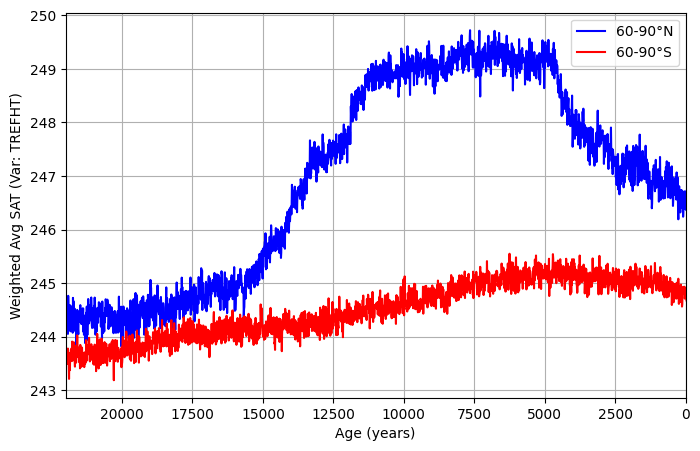

In [6]:
weighted_avg_orb_60s = calculate_weighted_avg_sat(trace_orb_sat, lat_min=-90, lat_max=-60)
weighted_avg_orb_60n= calculate_weighted_avg_sat(trace_orb_sat, lat_min=60, lat_max=90)

sat_series_orb_60s = weighted_avg_orb_60s.to_series()
sat_series_orb_60n = weighted_avg_orb_60n.to_series()


import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import zscore

# Create the plot
plt.figure(figsize=(8, 5))

plt.plot(sat_series_orb_60n.index, (sat_series_orb_60n)+273.15, 'b-', alpha=1, label="60-90°N")
plt.plot(sat_series_orb_60s.index, (sat_series_orb_60s)+273.15, 'r-', alpha=1, label="60-90°S")

# plt.plot(smoothed_sat_orb.index, (smoothed_sat_orb+smoothed_sat_ghg)+23, 'g-', alpha=1, label="GHG+Orb")
# set x-axis limits
plt.xlim([0, 22000])
# invert the x-axis
plt.gca().invert_xaxis()
# plt.ylim([-23.5, -19])
plt.xlabel('Age (years)')
plt.ylabel('Weighted Avg SAT (Var: TREFHT)')
# plt.title('Weighted Average SAT and its 20-pt Moving Average')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
trace_orb_sat = trace_orb[['TS']]
trace_orb_sat = trace_orb_sat.rename({'TS': 'sat'})

trace_orb_sat = trace_orb_sat.rename({'time': 'age'})
trace_orb_sat['age'] = trace_orb_sat['age'] * -1000
trace_orb_sat['sat'] = trace_orb_sat['sat'] - 273.15 # convert to Celsius


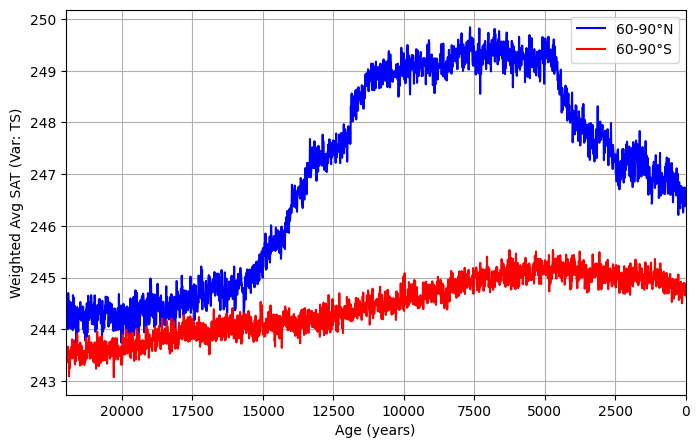

In [9]:
weighted_avg_orb_60s = calculate_weighted_avg_sat(trace_orb_sat, lat_min=-90, lat_max=-60)
weighted_avg_orb_60n= calculate_weighted_avg_sat(trace_orb_sat, lat_min=60, lat_max=90)

sat_series_orb_60s = weighted_avg_orb_60s.to_series()
sat_series_orb_60n = weighted_avg_orb_60n.to_series()


import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import zscore

# Create the plot
plt.figure(figsize=(8, 5))

plt.plot(sat_series_orb_60n.index, (sat_series_orb_60n)+273.15, 'b-', alpha=1, label="60-90°N")
plt.plot(sat_series_orb_60s.index, (sat_series_orb_60s)+273.15, 'r-', alpha=1, label="60-90°S")

# plt.plot(smoothed_sat_orb.index, (smoothed_sat_orb+smoothed_sat_ghg)+23, 'g-', alpha=1, label="GHG+Orb")
# set x-axis limits
plt.xlim([0, 22000])
# invert the x-axis
plt.gca().invert_xaxis()
# plt.ylim([-23.5, -19])
plt.xlabel('Age (years)')
plt.ylabel('Weighted Avg SAT (Var: TS)')
# plt.title('Weighted Average SAT and its 20-pt Moving Average')
plt.legend()
plt.grid(True)
plt.show()
